## Basic Import

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm

from torchcp.regression.loss import QuantileLoss
from torchcp.regression.predictors import SplitPredictor, ACI, CQR
from torchcp.classification import Metrics
from torchcp.utils import fix_randomness

from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Heper-parameters

In [2]:
epochs = 100
alpha = 0.05

## Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset: Communaties-Crime

In [4]:
fix_randomness(seed=1)

base_path = '../dataset/'
attrib = pd.read_csv(base_path + 'attributes.csv', delim_whitespace=True)
data = pd.read_csv(base_path + 'communities.data', names=attrib['attributes'])
data = data.drop(columns=['state', 'county',
                          'community', 'communityname',
                          'fold'], axis=1)
data = data.replace('?', np.nan)

# Impute mean values for samples with missing values
data['OtherPerCap'] = data['OtherPerCap'].astype("float")
mean_value = data['OtherPerCap'].mean()
data['OtherPerCap'].fillna(value=mean_value, inplace=True)
data = data.dropna(axis=1)
X = data.iloc[:, 0:100].values
y = data.iloc[:, 100].values
X = X.astype(np.float32)
y = y.astype(np.float32)

indices = np.arange(X.shape[0])
np.random.shuffle(indices)
split_index1 = int(len(indices) * 0.4)
split_index2 = int(len(indices) * 0.6)
part1, part2, part3 = np.split(indices, [split_index1, split_index2])
scalerX = StandardScaler()
scalerX = scalerX.fit(X[part1, :])
train_dataset = TensorDataset(torch.from_numpy(scalerX.transform(X[part1, :])), torch.from_numpy(y[part1]))
cal_dataset = TensorDataset(torch.from_numpy(scalerX.transform(X[part2, :])), torch.from_numpy(y[part2]))
test_dataset = TensorDataset(torch.from_numpy(scalerX.transform(X[part3, :])), torch.from_numpy(y[part3]))

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=100, shuffle=False, num_workers=2)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

## Model: NonLinearNet

In [5]:
class NonLinearNet(nn.Module):
            def __init__(self, in_shape, out_shape, hidden_size, dropout):
                super(NonLinearNet, self).__init__()
                self.hidden_size = hidden_size
                self.in_shape = in_shape
                self.out_shape = out_shape
                self.dropout = dropout
                self.base_model = nn.Sequential(
                    nn.Linear(self.in_shape, self.hidden_size),
                    nn.ReLU(),
                    nn.Dropout(self.dropout),
                    nn.Linear(self.hidden_size, self.hidden_size),
                    nn.ReLU(),
                    nn.Dropout(self.dropout),
                    nn.Linear(self.hidden_size, self.out_shape),
                )

            def forward(self, x):
                return self.base_model(x)

## Train & Comformal Prediction

In [6]:
def train(model, device, epoch, train_data_loader, criterion, optimizer):
    for index, (tmp_x, tmp_y) in enumerate(train_data_loader):
        outputs = model(tmp_x.to(device))
        loss = criterion(outputs, tmp_y.unsqueeze(dim=1).to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def c_prediction(model, predictor):
    model.eval()

    predictor = predictor(model)
    predictor.calibrate(cal_data_loader, alpha)              
    result = predictor.evaluate(test_data_loader)
    print(f"Result--Coverage_rate: {result['Coverage_rate']}, Average_size: {result['Average_size']}")
    return result['Coverage_rate'],result['Average_size']

## Experiment

In [7]:
quantiles = [alpha / 2, 1 - alpha / 2]
predictors = [SplitPredictor, CQR]
criterions = [nn.MSELoss(), QuantileLoss(quantiles)]
models = [NonLinearNet(X.shape[1], 1, 64, 0.5).to(device), NonLinearNet(X.shape[1], 2, 64, 0.5).to(device)]
setting = ['SP','CQR']
Coverage_rates = []
Average_sizes = []

## Conformal Prediction

In [8]:
for predictor, criterion, model in zip(predictors, criterions, models):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(epochs):
        train(model, device, epoch, train_data_loader, criterion, optimizer)

    Coverage_rate, Average_size = c_prediction(model, predictor)
    Coverage_rates.append(Coverage_rate)
    Average_sizes.append(Average_size)

Result--Coverage_rate: 0.9411027431488037, Average_size: 0.7211230397224426
Result--Coverage_rate: 0.9348371028900146, Average_size: 0.5303559899330139


## Visualization

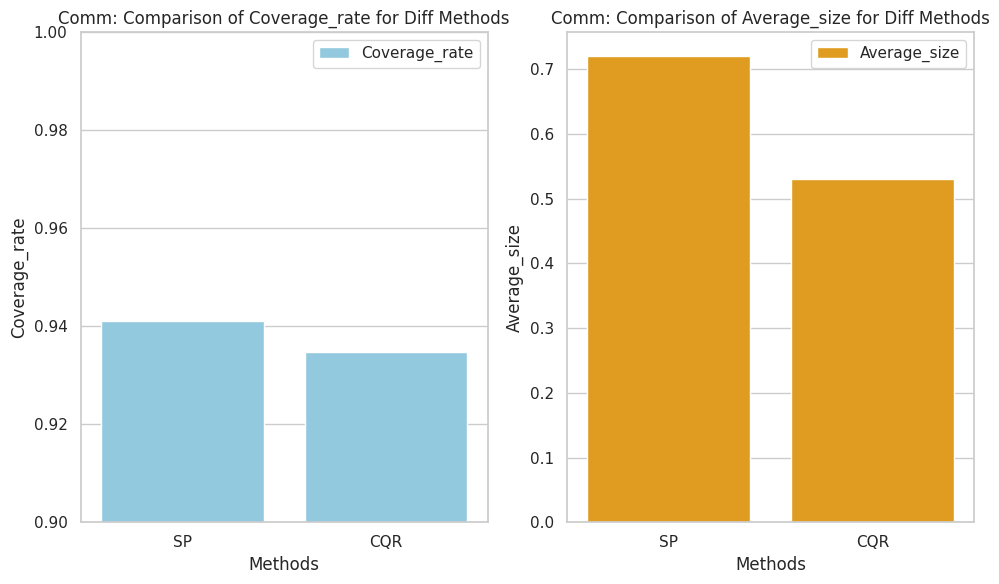

In [11]:
sns.set_theme()
sns.set(style="whitegrid", palette="deep")

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=setting, y=Coverage_rates,  color='skyblue', label='Coverage_rate')

plt.xlabel('Methods')
plt.ylabel('Coverage_rate')
plt.title('Comm: Comparison of Coverage_rate for Diff Methods')
# plt.xticks(rotation=45, ha='right')
plt.ylim(0.9,1)
plt.legend()

plt.subplot(1, 2, 2)
sns.barplot(x=setting, y=Average_sizes,  color='orange', label='Average_size')
#sns.barplot(x='Model', y='Top-3 Accuracy', data=df, color='orange', label='Top-3 Accuracy')

plt.xlabel('Methods')
plt.ylabel('Average_size')
plt.title('Comm: Comparison of Average_size for Diff Methods')
# plt.xticks(rotation=45, ha='right')
plt.ylim()
plt.legend()

plt.tight_layout()
plt.show()